ds    y
0   1949-01-01  112
1   1949-02-01  118
2   1949-03-01  132
3   1949-04-01  129
4   1949-05-01  121
..         ...  ...
139 1960-08-01  606
140 1960-09-01  508
141 1960-10-01  461
142 1960-11-01  390
143 1960-12-01  432

[144 rows x 2 columns]

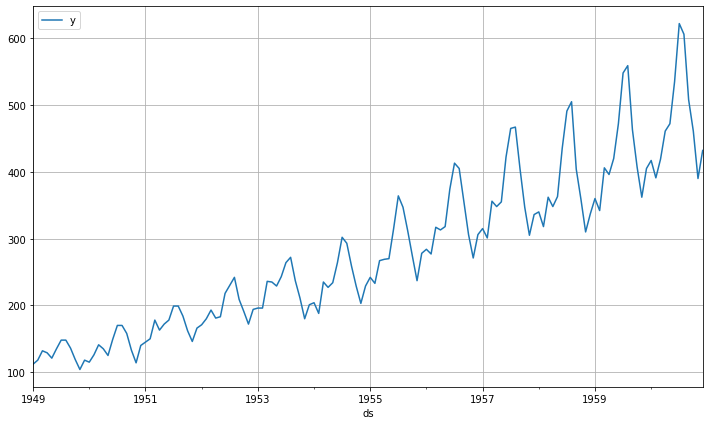

In [65]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.ticker as ticker


# TODO:
# https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3


# REQUISITO IMPORTANTE:
# El df debe tener una columna llamada "ds", la fecha
# y una columna llamada "y" los valores.

df = pd.read_csv('../../../data/raw/AirPassengers.csv',
                      na_values=".",
                      parse_dates=True,
                      names=['ds', 'y'],
                      header=0,
                      infer_datetime_format=True
                      ).dropna()

df["ds"] = pd.to_datetime(df["ds"])

display(df)

df[['ds','y']].plot('ds', figsize=(12,7), grid=True)

In [66]:
# Queremos predecir el último año, 1961 entero, el train acaba en 1960
# La granularidad de train es mensual, el futuro dataframe también debe
# Si train solo tiene datos de 00:00 a 06:00 el test debe ser igual
# O puedes usar mcmc_samples para contemplar su incertidumbre intermedia

# MODELO SEMI COMPLETO, CON PARTES COMENTADAS PORQUE 
# AUTOMÁTICAMENTE SE AJUSTA MEJOR QUE MANUALMENTE

playoffs = pd.DataFrame({
    'holiday': 'playoff',
    'ds': pd.to_datetime(['1958-01-13', '1959-01-03']),
    # Dias antes o después que afectan las vacaciones
    'lower_window': 0,
    'upper_window': 1,
})
superbowls = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['1958-02-07', '1959-02-02']),
    'lower_window': 0,
    'upper_window': 1,
})
holidays = pd.concat((playoffs, superbowls))



m = Prophet(growth='linear',  # Linear or logistic
    interval_width=0.95,  # Int conf global trend
#     mcmc_samples=300,   # Int conf seasonal trend
#     holidays=holidays,
    seasonality_mode='multiplicative',  # Aditive or multiplicative
            
#     changepoint_prior_scale=30,
#     #changepoint_prior_scale=0.01,  # Prueba a cambiar el valory obvserva los changepoints
    changepoints=['1954-06-01'],
#     seasonality_prior_scale=35,
#     holidays_prior_scale=20,

    daily_seasonality=False,  
    weekly_seasonality=False,
#     yearly_seasonality=False,
    yearly_seasonality=5,  # Orden de Fourier
    )
#    .add_seasonality(
#         name='monthly',
#         period=30.5,
#         fourier_order=55
#    ).add_seasonality(
#         name='daily',
#         period=1,
#         fourier_order=15
#    ).add_seasonality(
#         name='yearly',
#         period=365.25,
#         fourier_order=4
#    ).add_seasonality(
#         name='weekly',
#         period=7,
#         fourier_order=20
#    ).add_seasonality(
#         name='quartely',
#         period=365.25/4,
#         fourier_order=5,
#         prior_scale=15
#    )   

# Tratamiento de outliers
df.loc[(df['ds'] > '1958-10-01') & (df['ds'] < '1959-05-01'), 'y'] = None


m.fit(df)

future = m.make_future_dataframe(periods=24, freq="M")
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
163 1962-07-31  693.098245  668.029475  717.472816
164 1962-08-31  590.762869  566.177622  616.511697
165 1962-09-30  518.573816  494.044390  542.376835
166 1962-10-31  454.411111  430.732382  480.417865
167 1962-11-30  503.293626  475.845187  528.430897

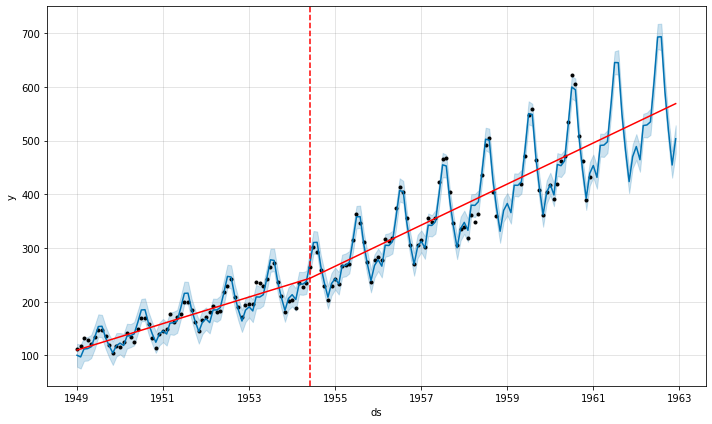

In [67]:
from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

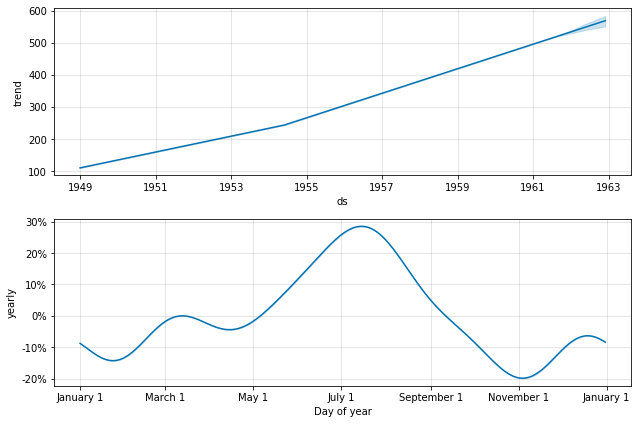

In [68]:
fig2 = m.plot_components(forecast)

In [69]:
""" 
    Entrena el modelo con un periodo que especificas [initial]. 
    Después predice con otro periodo que le has concretado también 
    [horizon]. Después entrena con un conjunto más grande que el 
    primero para entrenar con otro conjunto pasado un tiempo que 
    tambien le especificas [period].
"""

from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, 
                         initial = pd.to_timedelta(12*30, unit="D"),     # El tamaño del entrenamiento
                         period = pd.to_timedelta(6*30, unit="D"),      # El tamaño del salto hacia futuro
                         horizon = pd.to_timedelta(12*30, unit="D"))   # El tamaño del test
df_cv.head()

INFO:fbprophet:Making 21 forecasts with cutoffs between 1950-01-28 00:00:00 and 1959-12-07 00:00:00


ds        yhat  yhat_lower  yhat_upper      y     cutoff
0 1950-02-01  119.951702  118.202062  121.845907  126.0 1950-01-28
1 1950-03-01  136.475372  134.741012  137.994127  141.0 1950-01-28
2 1950-04-01  131.537598  130.001575  133.181498  135.0 1950-01-28
3 1950-05-01  125.123641  123.440310  126.866638  125.0 1950-01-28
4 1950-06-01  137.477987  135.888103  139.169177  149.0 1950-01-28

In [70]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

horizon         mse       rmse       mae      mape     mdape  coverage
0 36 days  131.780123  11.479552  8.821558  0.037981  0.029679  0.652174
1 37 days  147.167230  12.131250  9.536084  0.040404  0.029679  0.652174
2 41 days  146.048834  12.085067  9.372138  0.039581  0.028354  0.652174
3 42 days  160.019727  12.649890  9.869277  0.039006  0.028354  0.652174
4 43 days  159.746795  12.639098  9.839933  0.039096  0.028354  0.652174

In [71]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

# Calcula una métrica custom: MAPE
mape_baseline = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
print(mape_baseline)  # Hemos fallado de media 4.8% de las muestras

4.777783702365467


ds        yhat  yhat_lower  yhat_upper
163 1962-08-01  689.446983  663.611818  719.274967
164 1962-09-01  586.955753  562.145991  612.365852
165 1962-10-01  515.415851  493.768880  542.165573
166 1962-11-01  453.286552  428.794601  479.107149
167 1962-12-01  505.258857  477.085879  534.495249

INFO:fbprophet:Making 21 forecasts with cutoffs between 1950-01-28 00:00:00 and 1959-12-07 00:00:00


horizon         mse       rmse        mae      mape     mdape  coverage
0 36 days  719.100010  26.816040  13.884311  0.077283  0.017030  0.739130
1 37 days  598.374508  24.461695  12.144532  0.061211  0.017030  0.739130
2 41 days  602.344973  24.542717  12.125261  0.061221  0.016964  0.739130
3 42 days  617.801099  24.855605  12.858393  0.062375  0.017030  0.695652
4 43 days  643.681827  25.370885  13.812899  0.067550  0.023388  0.652174

12.488568935285688


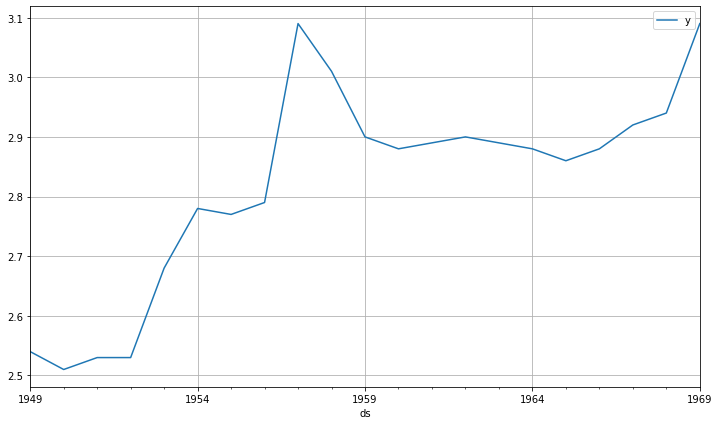

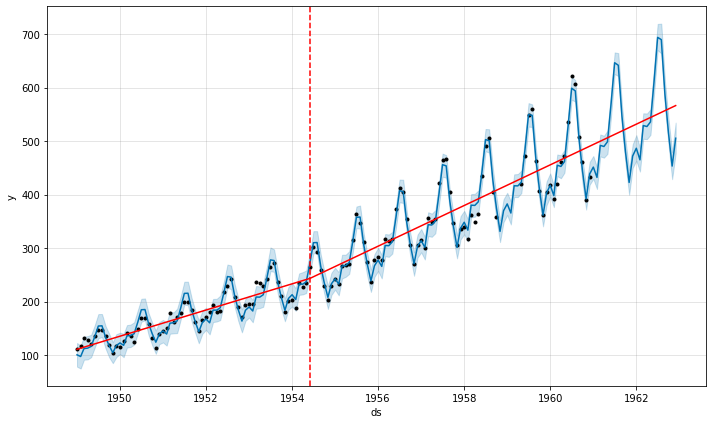

In [197]:
"""
    Usar otra serie temporal como regresor adicional.
    Esta ha de cubrir también el tiempo futuro que quieras
    prececir de la serie principal (lógico, como un X_test)
"""

# 1. Cargar los datos a predecir
df = pd.read_csv('../../../data/raw/AirPassengers.csv',
                      na_values=".",
                      parse_dates=True,
                      names=['ds', 'y'],
                      header=0,
                      infer_datetime_format=True
                      ).dropna()

df["ds"] = pd.to_datetime(df["ds"])
# Tratamiento de outliers
df.loc[(df['ds'] > '1958-10-01') & (df['ds'] < '1959-05-01'), 'y'] = None

# 2. Cargar y tratar los datos que enriquecerán a los anteriores
df_oil = pd.read_csv('../../../data/raw/U.S._Crude_Oil_First_Purchase_Price.csv',
                      na_values=".",
                      parse_dates=True,
                      names=['ds', 'y'],
                      header=0,
                      infer_datetime_format=True
                      ).dropna()

    # Convertir texto a tipo datetime
df_oil["ds"] = pd.to_datetime(df_oil["ds"], format='%Y')

    # Filtrar los años que nos interesan
df_oil = df_oil.loc[(df_oil['ds'] > '1948') & (df_oil['ds'] < '1970')]

    # Aumentar su granularidad de años a días
df_oil = df_oil.resample('MS', on='ds').mean()

    # Obtener los Nana como interpolación. 
    # CUIDADO! pone la columna 'ds' como índice
df_oil = df_oil.interpolate(method='linear') 
df_oil = df_oil.reset_index()

df_oil[['ds','y']].plot('ds', figsize=(12,7), grid=True)


# 3. Añades los datos que enriquecen con cuidado al df original
def oil_regressor(ds, dataframe):
    date = pd.to_datetime(ds)  # Una fecha concreta
    date = np.datetime64(date)
    if date in dataframe['ds'].values:
        return df_oil[df_oil['ds']==date].values[0][1]
    else:
        return None
    
df['oil_regressor'] = future['ds'].apply(oil_regressor, dataframe=df)


m = Prophet(growth='linear', 
    interval_width=0.95, 
    seasonality_mode='multiplicative',
    changepoints=['1954-06-01'],
    daily_seasonality=False,  
    weekly_seasonality=False,
    yearly_seasonality=5)

# 2. Señalas que la columna adicional
# es un regresor extra
m.add_regressor('oil_regressor')

m.fit(df)


# 3. Añades los datos que enriquecen al df futuro y predecir
future = m.make_future_dataframe(periods=12*2, freq="MS")
future['oil_regressor'] = future['ds'].apply(oil_regressor, dataframe=df_oil)
forecast = m.predict(future)

display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)




df_cv = cross_validation(m, 
                         initial = pd.to_timedelta(12*30, unit="D"),     # El tamaño del entrenamiento
                         period = pd.to_timedelta(6*30, unit="D"),      # El tamaño del salto hacia futuro
                         horizon = pd.to_timedelta(12*30, unit="D"))   # El tamaño del test
df_p = performance_metrics(df_cv)
display( df_p.head() )
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

# Calcula una métrica custom: MAPE
mape_baseline = mean_absolute_percentage_error(df_cv['y'], df_cv['yhat'])
print(mape_baseline)  # Hemos fallado de media 12.4% de las muestras. PEOR! pero bueno, sirve como ejemplo